# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, json

In [2]:
%matplotlib inline

# Classes

## Helper

In [3]:
class DecisionTreeHelper:

    def dictionary_depth_calculator(dictionary):
        if isinstance(dictionary, dict):
            return 1 + (max(map(DecisionTreeHelper.dictionary_depth_calculator, dictionary.values())) if dictionary else 0)
        return 0  

    def get_tree_depth(tree):
        return round(DecisionTreeHelper.dictionary_depth_calculator(tree) / 2) 

    def get_all_nested_dict_values(d):
        for v in d.values():
            if isinstance(v, dict):
                yield from DecisionTreeHelper.get_all_nested_dict_values(v)
            else:
                yield v

    def probability(count, sum):
        return count / sum

    def log2(num):
        return math.log2(num)
    
    def entropy(lst):
        lst = list(filter(lambda x: (x > 0), [float(i) for i in lst]))
        sum_lst = sum(lst)
        probabilities = [DecisionTreeHelper.probability(item, sum_lst) for item in lst]
        entropies = [-1*(p)*DecisionTreeHelper.log2(p) for p in probabilities]
        return sum(entropies) if len(entropies) > 0 else 0.0

    def print_dict(print_dict):
        print(json.dumps(print_dict, sort_keys=True, indent=4))     

    def is_nested_dict(tree):
        if type(tree) is dict:
            for value in tree.values():
                if type(value) is dict:
                    return True

        return False

    def ready_for_show_tree(tree):
        tree_to_show = tree.copy()
        for tree_to_show_attr, tree_to_show_value in tree_to_show.items():
            if type(tree_to_show_value) is dict:
                tree_to_show[tree_to_show_attr] = DecisionTreeHelper.ready_for_show_tree(tree_to_show_value)
            elif type(tree_to_show_value) is list:
                tree_to_show[tree_to_show_attr] = tree_to_show_value[0]
            else:
                tree_to_show[tree_to_show_attr] = tree_to_show_value
        
        return tree_to_show
    
    def show_tree(tree_to_show):
        DecisionTreeHelper.print_dict(DecisionTreeHelper.ready_for_show_tree(tree_to_show))

    def is_final_node(dic,features):
        if DecisionTreeHelper.is_node(dic, features):
            for attr, tree in dic.items():
                if DecisionTreeHelper.is_all_list(tree):
                    return True
        
        return False
    
    def is_all_list(dic):
        if type(dic) is dict:
            for attr, value in dic.items():
                if type(value) is not list:
                    return False

            return True
        else:
            return False
    
    def has_improvment(new, old, threshold):
        return new / old > (1 + (threshold / 100))

    def count_final_nodes(tree, features, i = 0):
        counter_tree = tree.copy()
        for attr, item in counter_tree.items():
            if DecisionTreeHelper.is_final_node(item, features):
                i += 1
                
            elif type(item) is dict:
                (counter_tree[attr], features, i) = DecisionTreeHelper.count_final_nodes(item, features, i)

        return (counter_tree, features, i)
    
    def is_node(dic, features):
        node = dic.copy()
        if type(node) is dict:
            if len(node) == 1:
                for attr, value in node.items():
                    if type(value) is dict and attr in features:
                        return True

        return False

    def node_counter(tree, features, i = 1):
        counter_tree = tree.copy()
        for attr, item in counter_tree.items():
            if DecisionTreeHelper.is_node(item, features):
                i += 1

            if type(item) is dict:
                (counter_tree[attr], features, i) = DecisionTreeHelper.node_counter(item, features, i)

        return (counter_tree, features, i)
    
    def node_count(tree, features):
        return DecisionTreeHelper.node_counter(tree, features)[2]

    def predictor(tree, row, default_label):
        pred_tree = tree.copy()
        if type(pred_tree) is dict:
            for key, value in pred_tree.items():
                if row[key] in value:
                    return DecisionTreeHelper.predictor(value[row[key]], row, default_label)
                else:
                    return default_label
        else:
            return pred_tree[0]

    def find_maximum_label(dataset, target_attribute):
        x_train = dataset.drop([target_attribute], axis=1)
        value_counts = dataset[target_attribute].value_counts().to_dict()
        return max(value_counts, key=value_counts.get)

    def dataframe_row_to_dict(dataframe):
        return list(dataframe[:1].to_dict('index').values())[0]


## Trainer

In [4]:
class DecisionTreeTrainer:

    train_dataset = None
    maximum_label = None
    target_attribute = ''
    tree = {}
    possible_values = {}

    def __init__(self, target_attribute, train_dataset):
        
        # Assign Class Variabels
        self.train_dataset = train_dataset
        self.target_attribute = target_attribute

        # Find Possible values
        self.find_possible_values()

        # Make Train
        self.train()
        self.compactor()

    def get(self):
        return self.tree

    def find_possible_values(self):
        values = {}
        examples = self.train_dataset
        for col in examples.columns:
            values[col] = examples[col].unique().tolist()

        self.possible_values = values

    def train(self):
        examples = self.train_dataset
        target_attribute = self.target_attribute

        self.maximum_label = DecisionTreeHelper.find_maximum_label(examples, target_attribute)
        self.tree = self.id3(examples, target_attribute, list(examples.drop([target_attribute], axis=1).columns))

    def id3(self, examples, target_attribute, attributes):
        possible_values = self.possible_values
        tree = {}
        value_counts = examples[target_attribute].value_counts().to_dict()
        voting_selection = max(value_counts, key=value_counts.get)
        return_values = [voting_selection, value_counts[voting_selection]]

        # If all examples are positive, Return the single-node tree Root, with label = +.
        # If all examples are negative, Return the single-node tree Root, with label = -.
        if len(value_counts) == 1:
            return return_values

        # If number of predicting attributes is empty, then Return the single node tree Root,
        # with label = most common value of the target attribute in the examples.
        elif not attributes:
            return return_values

        # Otherwise Begin
        else:
            # A ← The Attribute that best classifies examples.
            best = self.best_classifier(examples, attributes)
            tree[best] = {}
            # possible_values = list(examples[best].value_counts().to_dict().keys())
            possible_values = possible_values[best]
            remaining_attributes = [attribute for attribute in attributes if attribute != best]
            # Decision Tree attribute for Root = A.
            # For each possible value, vi, of A,
            for possible_value in possible_values:
                # Add a new tree branch below Root, corresponding to the test A = vi.
                # Let Examples(vi) be the subset of examples that have the value vi for A
                sub_example = examples[examples[best] == possible_value]
                # If Examples(vi) is empty
                if sub_example.empty:
                    # Then below this new branch add a leaf node with label = most common target value in the examples
                    tree[best][possible_value] = [voting_selection, 0]
                else:
                    # Else below this new branch add the subtree ID3 (Examples(vi), Target_Attribute, Attributes – {A})
                    tree[best][possible_value] = self.id3(sub_example, target_attribute, remaining_attributes)

            return tree
           
    def best_classifier(self, examples, attributes):
        target_attribute = self.target_attribute

        y_train = examples[target_attribute]
        x_train = examples.drop([target_attribute], axis=1)
        
        y_train_count = y_train.value_counts().to_list()
        all_entropy = DecisionTreeHelper.entropy(y_train_count)

        columns = list(x_train.columns)
        columns = list(filter(lambda column: column in attributes, columns))
        attributes = {x:[] for x in columns}
        for attribute in attributes.keys():
            attributes[attribute] = list(x_train[attribute].value_counts().keys())
        
        ig = {}
        
        for attribute, attribute_values in attributes.items():
            attribute_entropy = 0

            for attribute_value in attribute_values:
                list_values = y_train[x_train[attribute] == attribute_value].value_counts().to_list()
                entropy = DecisionTreeHelper.entropy(list_values)
                attribute_entropy += sum(list_values)/sum(y_train_count)*entropy
            
            ig[attribute] = all_entropy - attribute_entropy

        return max(ig, key=ig.get)  
    
    def compactor(self):
        tree = self.get()
        root = list(tree.keys())[0]
        old_tree = tree[root]
        while True:
            new_tree = self.single_compactor(old_tree)
            if new_tree == old_tree:
                break
            else:
                old_tree = new_tree

        return {
            root:new_tree
        }

    def single_compactor(self, tree):
        tree = self.dictionary_compactor(tree)
        if type(tree) is dict:
            for attribute, label in tree.items():
                tree[attribute] = self.single_compactor(label)
        
        return tree

    def dictionary_compactor(self, tree):
        if type(tree) is not dict:
            return tree
        
        list_of_values = list(DecisionTreeHelper.get_all_nested_dict_values(tree))
        labels = set(list(map(lambda x: x[0], list_of_values)))

        if len(labels) == 1:
            result = [list(labels)[0], 0]
            for item in list_of_values:
                result[1] += item[1]
            return result

        return tree

    def get_target(self):
        return self.target_attribute

    def get_dataset(self):
        return self.train_dataset
    
    def get_maximum_label(self):
        return self.maximum_label

    def get_features(self):
        features = list(self.train_dataset.columns)
        features.remove(self.target_attribute)
        return features

    def get_count_nodes(self):
        return DecisionTreeHelper.node_count(self.get(), self.get_features())

    def predictor(self, row):
        return DecisionTreeHelper.predictor(self.get(), row, self.maximum_label)


## Tester

In [5]:
class DecisionTreeTester:

    tree = None
    target_attribute = None
    default_label = None
    test_dataset = None
    accuracy = 0.0

    def __init__(self, tree, target_attribute, test_dataset, default_label = None):
        self.tree = tree.copy()
        self.target_attribute = target_attribute
        self.test_dataset = test_dataset
        self.default_label = default_label

        self.test()
    
    def test(self):
        target_attribute = self.target_attribute
        test_dataset = self.test_dataset
        tree = self.tree

        result = []

        for i, row in test_dataset.iterrows():
            row = dict(row)
            res = DecisionTreeHelper.predictor(tree, row, self.default_label)
            result.append(res == row[target_attribute])

        self.accuracy = sum(result) / len(result)
    
    def get_accuracy(self):
        return self.accuracy * 100


## Pruning

In [6]:
class DecisionTreePruning:

    train_dataset = None
    pruning_dataset = None
    trainer = None
    target_attribute = ''
    tree = {}
    threshold = 0
    accuracies = []
    node_counts = 0
    features = []

    def __init__(self, trainer, pruning_dataset, threshold = 0):
        self.tree = trainer.get().copy()
        self.target_attribute = trainer.target_attribute
        self.node_counts = trainer.get_count_nodes()
        self.features = trainer.get_features().copy()
        self.train_dataset = trainer.get_dataset()

        self.pruning_dataset = pruning_dataset
        self.threshold = threshold

        self.pruning()

    def pruning(self):
        selected_tree = self.tree
        target_attribute = self.target_attribute
        pruning_dataset = self.pruning_dataset
        train_dataset = self.train_dataset
        threshold = self.threshold
        features = self.features.copy()

        accuracy = DecisionTreeTester(selected_tree, target_attribute, pruning_dataset).get_accuracy()
        
        ps_accuracies = [
            {
                'node': self.node_counts,
                'train_accuracy':  DecisionTreeTester(selected_tree, target_attribute, train_dataset).get_accuracy(),
                'validation_accuracy': accuracy,
                'tree': selected_tree
            }
        ]

        while True:
            tree_list = []
            final_nodes = DecisionTreeHelper.count_final_nodes(selected_tree, features)[2]
            
            for i in range(1, final_nodes + 1):
                dct = {}
                dct['tree'] = self.pruning_single_node(selected_tree, i)[0]
                dct['validation_accuracy'] = DecisionTreeTester(dct['tree'], target_attribute, pruning_dataset).get_accuracy()

                if DecisionTreeHelper.has_improvment(dct['validation_accuracy'], accuracy, threshold):
                    tree_list.append(dct)
                
            
            if tree_list:
                tree_list.sort(key=lambda e: e['validation_accuracy'], reverse=True)
                self.node_counts += -1
                selected_tree = tree_list[0]['tree']
                train_accuracy = DecisionTreeTester(tree_list[0]['tree'], target_attribute, train_dataset).get_accuracy()
                accuracy = tree_list[0]['validation_accuracy']

                ps_accuracies.append({
                    'node': self.node_counts,
                    'train_accuracy': train_accuracy,
                    'validation_accuracy': accuracy,
                    'tree': selected_tree
                })
            else:
                break
            
        self.accuracies = ps_accuracies.copy()
        self.tree = selected_tree.copy()

    def pruning_single_node(self, tree, target, i = 0):
        psn_tree = tree.copy()
        features = self.features.copy()

        for attr, item in psn_tree.items():
            if DecisionTreeHelper.is_final_node(item, features):
                i += 1
                if target == i:
                    result = {}
                    for attr2, item2 in item.items():
                        for attr3, item3 in item2.items():
                            label, count = item3
                            if not label in result:
                                result[label] = 0

                            result[label] += count

                    label = max(result, key=result.get)
                    psn_tree[attr] = [label, result[label]]
                    return (psn_tree, i)
                
            elif type(item) is dict:
                (psn_tree[attr], i) = self.pruning_single_node(item, target, i)

        return (psn_tree, i)

    def get(self):
        return self.tree
    
    def get_target(self):
        return self.target_attribute
    
    def get_accuracies(self):
        return self.accuracies
    
    def get_accuracy(self):
        return self.accuracies[-1]['validation_accuracy']

    def predictor(self, row):
        return DecisionTreeHelper.predictor(self.get(), row, self.maximum_label)


## Fold Cross Validation

In [7]:
class DecisionTreeFoldCrossValidation:

    fold_number = 0
    pruning_threshold = 0.0
    primary_dataset = None
    train_dataset = []
    validation_dataset = []
    test_dataset = None
    target_attribute = ''
    trees = []
    maximum_label = ''
    accuracies = []
    accuracy = []

    def __init__(self, primary_dataset, test_dataset, target_attribute, fold_number = 4, pruning_threshold = 0.0):
        self.fold_number = fold_number
        self.primary_dataset = primary_dataset
        self.test_dataset = test_dataset
        self.target_attribute = target_attribute
        self.pruning_threshold = pruning_threshold

        self.randomizer()
        self.divider()
        self.plant_trees()
        self.find_maximum_label()
        self.test()
    
    def randomizer(self):
        self.primary_dataset = self.primary_dataset.sample(frac=1)

    def divider(self):
        primary_dataset = self.primary_dataset
        primary_dataset_len = len(primary_dataset.index)
        fold_number = self.fold_number
        train_dataset = []
        validation_dataset = []
        data_bounds = {
            'train_dataset': [],
            'validation_dataset': []
        }

        for i in range(fold_number):
            data_bounds['train_dataset'].append([
                [0, int(float((fold_number - i - 1)) / float(fold_number)*primary_dataset_len)],
                [int(float((fold_number - i)) / float(fold_number)*primary_dataset_len), int(float((fold_number)) / float(fold_number)*primary_dataset_len)]
            ])

            data_bounds['validation_dataset'].append([int(float((fold_number - i - 1)) / float(fold_number)*primary_dataset_len), int(float((fold_number - i)) / float(fold_number)*primary_dataset_len)])

        for i in range(fold_number):
            train_dataset.append(pd.concat([
                primary_dataset[data_bounds['train_dataset'][i][0][0]:data_bounds['train_dataset'][i][0][1]],
                primary_dataset[data_bounds['train_dataset'][i][1][0]:data_bounds['train_dataset'][i][1][1]]
            ]))

            validation_dataset.append(pd.concat([
                primary_dataset[data_bounds['validation_dataset'][i][0]:data_bounds['validation_dataset'][i][1]],
            ]))
        
        self.train_dataset = train_dataset.copy()
        self.validation_dataset = validation_dataset.copy()

    def plant_trees(self):

        train_dataset = self.train_dataset.copy()
        validation_dataset = self.validation_dataset.copy()
        pruning_threshold = self.pruning_threshold
        fold_number = self.fold_number
        trees = []

        for i in range(fold_number):
            trainer = DecisionTreeTrainer('Class', train_dataset[i])
            pruning = DecisionTreePruning(trainer, validation_dataset[i], pruning_threshold)
            trees.append([trainer, pruning])

        self.trees = trees.copy()
    
    def find_maximum_label(self):
        maximum_label = DecisionTreeHelper.find_maximum_label(self.primary_dataset, self.target_attribute)

    def predictor(self, row):
        predictions = []
        for i in range(self.fold_number):
            trained, pruned = self.get()[i]
            predictions.append({
                'label': DecisionTreeHelper.predictor(pruned.get(), row, self.maximum_label),
                'tree_accuracy' : pruned.get_accuracy()
            })
        return predictions

    def test(self):
        test_dataset = self.test_dataset
        target_attribute = self.target_attribute
        maximum_label = self.maximum_label
        trees = self.trees.copy()
        fold_number = self.fold_number
        accuracies_result = []
        accuracy_result = []

        for i in range(self.fold_number):
            trainer, pruning = trees[i].copy()
            pruning_accuracies = pruning.get_accuracies().copy()
            for j in range(len(pruning_accuracies)):
                pruning_accuracies[j]['test_accuracy'] = DecisionTreeTester(pruning_accuracies[j]['tree'], target_attribute, test_dataset, maximum_label).get_accuracy()
                del pruning_accuracies[j]['tree']
            
            accuracy_result.append(pruning_accuracies[-1])
            accuracies_result.append(pruning_accuracies)

        self.accuracy = accuracy_result
        self.accuracies = accuracies_result

    def get(self):
        return self.trees

    def get_accuracies(self):
        return self.accuracies
    
    def get_accuracy(self):
        return self.accuracy
        


# Exercise

In [8]:
labels = ['Class', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

train_dataset = pd.read_csv('/content/drive/MyDrive/Datasets/adult.train.10k.discrete', header=None, names=labels)
test_dataset = pd.read_csv('/content/drive/MyDrive/Datasets/adult.test.10k.discrete', header=None, names=labels)

train_dataset = train_dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)
test_dataset = test_dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)

target_attribute = 'Class'

## Question 1

### Do actions

In [447]:
question1_train_accuracy = {}
question1_test_accuracy = {}
question1_node_counts = {}
question1_depth = {}

In [448]:
for j in [30, 40, 50, 60, 70, 100]:
    question1_train_accuracy[j] = []
    question1_test_accuracy[j] = []
    question1_node_counts[j] = []
    question1_depth[j] = []

    for i in range(3):
        q1_train_dataset = train_dataset.sample( n = j * 100 )
        q1_test_dataset = test_dataset
        q1_trainer = DecisionTreeTrainer(target_attribute, q1_train_dataset)
        q1_tree = q1_trainer.get()
        q1_node_counts = q1_trainer.get_count_nodes()
        q1_depth = DecisionTreeHelper.get_tree_depth(q1_tree)

        q1_tester = DecisionTreeTester(q1_tree, target_attribute, q1_test_dataset, q1_trainer.get_maximum_label())
        q1_accuracy = q1_tester.get_accuracy()

        q1_tester2 = DecisionTreeTester(q1_tree, target_attribute, q1_train_dataset, q1_trainer.get_maximum_label())
        q1_accuracy2 = q1_tester2.get_accuracy()

        question1_train_accuracy[j].append(q1_accuracy2)
        question1_test_accuracy[j].append(q1_accuracy)
        question1_node_counts[j].append(q1_node_counts)
        question1_depth[j].append(q1_depth)

        print(f'For {j}% Train Accuracy: {q1_accuracy2}, Test Accuracy: {q1_accuracy}, Node Counts: {q1_node_counts}, Depth: {q1_depth}')
        # DecisionTreeHelper.show_tree(q1_tree)

    print('')

For 30% Train Accuracy: 88.56666666666668, Test Accuracy: 79.67, Node Counts: 187, Depth: 7
For 30% Train Accuracy: 89.33333333333333, Test Accuracy: 79.69000000000001, Node Counts: 177, Depth: 7
For 30% Train Accuracy: 90.16666666666666, Test Accuracy: 79.4, Node Counts: 198, Depth: 7

For 40% Train Accuracy: 88.275, Test Accuracy: 80.17999999999999, Node Counts: 232, Depth: 7
For 40% Train Accuracy: 88.425, Test Accuracy: 78.89, Node Counts: 216, Depth: 8
For 40% Train Accuracy: 88.9, Test Accuracy: 79.84, Node Counts: 246, Depth: 7

For 50% Train Accuracy: 88.0, Test Accuracy: 79.95, Node Counts: 273, Depth: 8
For 50% Train Accuracy: 88.7, Test Accuracy: 80.41, Node Counts: 265, Depth: 7
For 50% Train Accuracy: 89.02, Test Accuracy: 79.89, Node Counts: 261, Depth: 8

For 60% Train Accuracy: 88.26666666666667, Test Accuracy: 80.19, Node Counts: 326, Depth: 7
For 60% Train Accuracy: 88.18333333333334, Test Accuracy: 80.63, Node Counts: 324, Depth: 8
For 60% Train Accuracy: 88.35, Test

### Plot

In [449]:
print(question1_train_accuracy)
print(question1_test_accuracy)
print(question1_node_counts)
print(question1_depth)

{30: [88.56666666666668, 89.33333333333333, 90.16666666666666], 40: [88.275, 88.425, 88.9], 50: [88.0, 88.7, 89.02], 60: [88.26666666666667, 88.18333333333334, 88.35], 70: [88.18571428571428, 88.17142857142856, 87.91428571428571], 100: [87.53999999999999, 87.53999999999999, 87.53999999999999]}
{30: [79.67, 79.69000000000001, 79.4], 40: [80.17999999999999, 78.89, 79.84], 50: [79.95, 80.41, 79.89], 60: [80.19, 80.63, 80.17], 70: [80.13, 80.36999999999999, 80.58999999999999], 100: [80.78999999999999, 80.76, 80.88]}
{30: [187, 177, 198], 40: [232, 216, 246], 50: [273, 265, 261], 60: [326, 324, 312], 70: [362, 342, 349], 100: [431, 437, 437]}
{30: [7, 7, 7], 40: [7, 8, 7], 50: [8, 7, 8], 60: [7, 8, 7], 70: [8, 8, 8], 100: [8, 8, 8]}


In [452]:
question1_train_accuracy_avg = {}
question1_test_accuracy_avg = {}
question1_node_counts_avg = {}
question1_depth_avg = {}
x = [30, 40, 50, 60, 70, 100]

for i in x:
    question1_train_accuracy_avg[i] = sum(question1_train_accuracy[i]) / len(question1_train_accuracy[i])
    question1_test_accuracy_avg[i] = sum(question1_test_accuracy[i]) / len(question1_test_accuracy[i])
    question1_node_counts_avg[i] = sum(question1_node_counts[i]) / len(question1_node_counts[i])
    question1_depth_avg[i] = sum(question1_depth[i]) / len(question1_depth[i])

question1_train_accuracy_avg_list = []
question1_test_accuracy_avg_list = []
question1_node_counts_avg_list = []
question1_depth_avg_list = []

for i in x:
    question1_train_accuracy_avg_list.append(question1_train_accuracy_avg[i])
    question1_test_accuracy_avg_list.append(question1_test_accuracy_avg[i])
    question1_node_counts_avg_list.append(question1_node_counts_avg[i])
    question1_depth_avg_list.append(question1_depth_avg[i])

print(question1_train_accuracy_avg_list)
print(question1_test_accuracy_avg_list)
print(question1_node_counts_avg_list)
print(question1_depth_avg_list)

[89.35555555555555, 88.53333333333335, 88.57333333333332, 88.26666666666665, 88.09047619047618, 87.54]
[79.58666666666667, 79.63666666666667, 80.08333333333333, 80.33, 80.36333333333333, 80.81]
[187.33333333333334, 231.33333333333334, 266.3333333333333, 320.6666666666667, 351.0, 435.0]
[7.0, 7.333333333333333, 7.666666666666667, 7.333333333333333, 8.0, 8.0]


Text(0.5, 1.0, 'Depth')

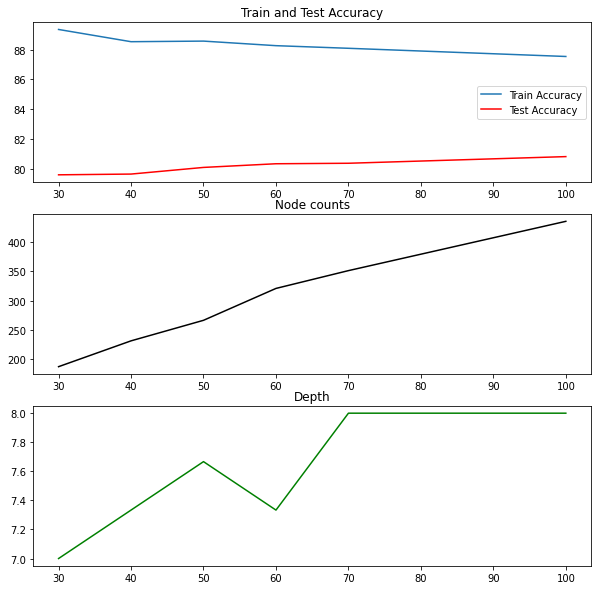

In [482]:
fig, (ax1, ax2, ax3) = plt.subplots(3)

fig.set_figheight(10)
fig.set_figwidth(10)

ax1.plot(x, question1_train_accuracy_avg_list, label='Train Accuracy')
ax1.plot(x, question1_test_accuracy_avg_list, 'r', label='Test Accuracy')
ax1.set_title('Train and Test Accuracy')
ax1.legend()

ax2.plot(x, question1_node_counts_avg_list, 'k')
ax2.set_title('Node counts')

ax3.plot(x, question1_depth_avg_list, 'g')
ax3.set_title('Depth')


## Question 2

#### Section A


In [461]:
train_dataset_sample = train_dataset.sample(frac = 1)
q2_train_dataset = train_dataset_sample[:7500]
q2_validation_dataset = train_dataset_sample[7500:]
q2_test_dataset = test_dataset

In [471]:
q2_trainer = DecisionTreeTrainer(target_attribute, q2_train_dataset)

In [472]:
q2_pruner = DecisionTreePruning(q2_trainer, q2_validation_dataset)

In [487]:
q2_accuracies = q2_pruner.get_accuracies().copy()

for i in range(len(q2_accuracies)):
    if 'tree' in q2_accuracies[i]:
        q2_accuracies[i]['test_accuracy'] = DecisionTreeTester(q2_accuracies[i]['tree'], target_attribute, q2_test_dataset, q2_trainer.get_maximum_label()).get_accuracy()
        del q2_accuracies[i]['tree']

In [499]:
q2_nodes = []
q2_train_accuracies = []
q2_validation_accuracies = []
q2_test_accuracies = []

for i in range(len(q2_accuracies)):
    q2_nodes.append(q2_accuracies[i]['node'])
    q2_train_accuracies.append((100 - q2_accuracies[i]['train_accuracy']) / 100)
    q2_validation_accuracies.append((100 - q2_accuracies[i]['validation_accuracy']) / 100)
    q2_test_accuracies.append((100 - q2_accuracies[i]['test_accuracy']) / 100)

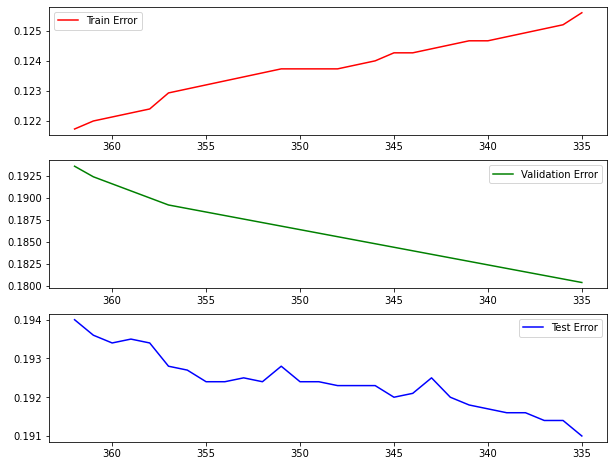

In [502]:
fig, (ax1, ax2, ax3) = plt.subplots(3)

fig.set_figheight(8)
fig.set_figwidth(10)

ax1.plot(q2_nodes, q2_train_accuracies, color='r', label='Train Error')
ax1.invert_xaxis()
ax1.legend()

ax2.plot(q2_nodes, q2_validation_accuracies, color='g', label='Validation Error')
ax2.invert_xaxis()
ax2.legend()

ax3.plot(q2_nodes, q2_test_accuracies, color='b', label='Test Error')
ax3.invert_xaxis()
ax3.legend()

#### Section C

In [512]:
q2_c_test_dataset_sample = test_dataset.sample(frac = 1)

q2_c_train_dataset = train_dataset
q2_c_validation_dataset = q2_c_test_dataset_sample[:2500]
q2_c_test_dataset = q2_c_test_dataset_sample[2500:]

In [513]:
q2_c_trainer = DecisionTreeTrainer(target_attribute, q2_c_train_dataset)

In [514]:
q2_c_pruner = DecisionTreePruning(q2_c_trainer, q2_c_validation_dataset)

In [515]:
q2_c_accuracies = q2_c_pruner.get_accuracies().copy()

for i in range(len(q2_c_accuracies)):
    if 'tree' in q2_c_accuracies[i]:
        q2_c_accuracies[i]['test_accuracy'] = DecisionTreeTester(q2_c_accuracies[i]['tree'], target_attribute, q2_c_test_dataset, q2_c_trainer.get_maximum_label()).get_accuracy()
        del q2_c_accuracies[i]['tree']

In [516]:
q2_c_nodes = []
q2_c_train_accuracies = []
q2_c_validation_accuracies = []
q2_c_test_accuracies = []

for i in range(len(q2_c_accuracies)):
    q2_c_nodes.append(q2_c_accuracies[i]['node'])
    q2_c_train_accuracies.append((100 - q2_c_accuracies[i]['train_accuracy']) / 100)
    q2_c_validation_accuracies.append((100 - q2_c_accuracies[i]['validation_accuracy']) / 100)
    q2_c_test_accuracies.append((100 - q2_c_accuracies[i]['test_accuracy']) / 100)

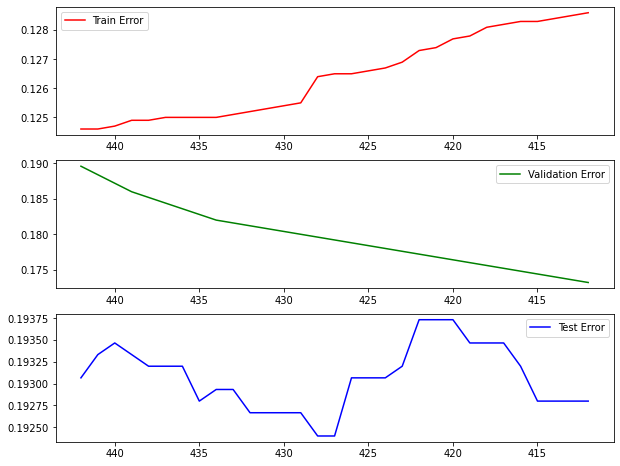

In [517]:
fig, (ax1, ax2, ax3) = plt.subplots(3)

fig.set_figheight(8)
fig.set_figwidth(10)

ax1.plot(q2_c_nodes, q2_c_train_accuracies, color='r', label='Train Error')
ax1.invert_xaxis()
ax1.legend()

ax2.plot(q2_c_nodes, q2_c_validation_accuracies, color='g', label='Validation Error')
ax2.invert_xaxis()
ax2.legend()

ax3.plot(q2_c_nodes, q2_c_test_accuracies, color='b', label='Test Error')
ax3.invert_xaxis()
ax3.legend()

#### Section D

In [14]:
q2d_train_dataset = train_dataset.sample(frac = 1)
q2d_test_dataset = test_dataset

In [15]:
q2d_fold = DecisionTreeFoldCrossValidation(q2d_train_dataset, q2d_test_dataset, target_attribute)

In [40]:
q2d_fold_accuracies = q2d_fold.get_accuracies().copy()

print(q2d_fold_accuracies[0])
print(q2d_fold_accuracies[1])
print(q2d_fold_accuracies[2])
print(q2d_fold_accuracies[3])

[{'node': 364, 'train_accuracy': 88.06666666666668, 'validation_accuracy': 79.72, 'test_accuracy': 80.71000000000001}, {'node': 363, 'train_accuracy': 88.03999999999999, 'validation_accuracy': 79.88, 'test_accuracy': 80.74}, {'node': 362, 'train_accuracy': 88.03999999999999, 'validation_accuracy': 80.0, 'test_accuracy': 80.73}, {'node': 361, 'train_accuracy': 88.02666666666667, 'validation_accuracy': 80.08, 'test_accuracy': 80.76}, {'node': 360, 'train_accuracy': 88.01333333333334, 'validation_accuracy': 80.12, 'test_accuracy': 80.76}, {'node': 359, 'train_accuracy': 87.98666666666666, 'validation_accuracy': 80.16, 'test_accuracy': 80.78}, {'node': 358, 'train_accuracy': 87.97333333333334, 'validation_accuracy': 80.2, 'test_accuracy': 80.78}, {'node': 357, 'train_accuracy': 87.94666666666666, 'validation_accuracy': 80.24, 'test_accuracy': 80.81}, {'node': 356, 'train_accuracy': 87.90666666666667, 'validation_accuracy': 80.28, 'test_accuracy': 80.82000000000001}, {'node': 355, 'train_ac

In [28]:
fold1 = [[], [], [], []]
fold2 = [[], [],[],[]]
fold3 = [[], [],[],[]]
fold4 = [[], [],[],[]]


for j in range(len(q2d_fold_accuracies[0])):
    fold1[0].append(q2d_fold_accuracies[0][j]['node'])
    fold1[1].append(1 - q2d_fold_accuracies[0][j]['train_accuracy']/100)
    fold1[2].append(1 - q2d_fold_accuracies[0][j]['validation_accuracy']/100)
    fold1[3].append(1 - q2d_fold_accuracies[0][j]['test_accuracy']/100)

for j in range(len(q2d_fold_accuracies[1])):
    fold2[0].append(q2d_fold_accuracies[1][j]['node'])
    fold2[1].append(1 - q2d_fold_accuracies[1][j]['train_accuracy']/100)
    fold2[2].append(1 - q2d_fold_accuracies[1][j]['validation_accuracy']/100)
    fold2[3].append(1 - q2d_fold_accuracies[1][j]['test_accuracy']/100)

for j in range(len(q2d_fold_accuracies[2])):
    fold3[0].append(q2d_fold_accuracies[2][j]['node'])
    fold3[1].append(1 - q2d_fold_accuracies[2][j]['train_accuracy']/100)
    fold3[2].append(1 - q2d_fold_accuracies[2][j]['validation_accuracy']/100)
    fold3[3].append(1 - q2d_fold_accuracies[2][j]['test_accuracy']/100)

for j in range(len(q2d_fold_accuracies[3])):
    fold4[0].append(q2d_fold_accuracies[3][j]['node'])
    fold4[1].append(1 - q2d_fold_accuracies[3][j]['train_accuracy']/100)
    fold4[2].append(1 - q2d_fold_accuracies[3][j]['validation_accuracy']/100)
    fold4[3].append(1 - q2d_fold_accuracies[3][j]['test_accuracy']/100)


Text(0.5, 1.0, 'Fold 4')

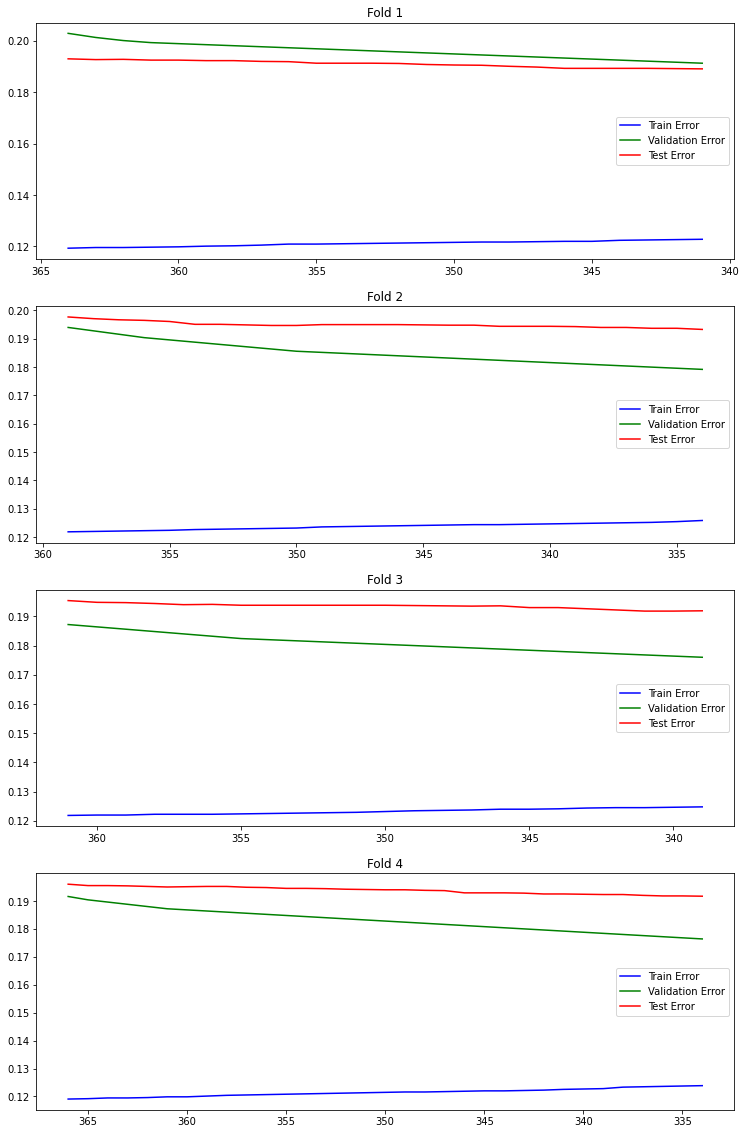

In [38]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)

fig.set_figheight(20)
fig.set_figwidth(12.5)

ax1.plot(fold1[0], fold1[1], color='b', label='Train Error')
ax1.plot(fold1[0], fold1[2], color='g', label='Validation Error')
ax1.plot(fold1[0], fold1[3], color='r', label='Test Error')
ax1.invert_xaxis()
ax1.legend()
ax1.set_title('Fold 1')

ax2.plot(fold2[0], fold2[1], color='b', label='Train Error')
ax2.plot(fold2[0], fold2[2], color='g', label='Validation Error')
ax2.plot(fold2[0], fold2[3], color='r', label='Test Error')
ax2.invert_xaxis()
ax2.legend()
ax2.set_title('Fold 2')

ax3.plot(fold3[0], fold3[1], color='b', label='Train Error')
ax3.plot(fold3[0], fold3[2], color='g', label='Validation Error')
ax3.plot(fold3[0], fold3[3], color='r', label='Test Error')
ax3.invert_xaxis()
ax3.legend()
ax3.set_title('Fold 3')

ax4.plot(fold4[0], fold4[1], color='b', label='Train Error')
ax4.plot(fold4[0], fold4[2], color='g', label='Validation Error')
ax4.plot(fold4[0], fold4[3], color='r', label='Test Error')
ax4.invert_xaxis()
ax4.legend()
ax4.set_title('Fold 4')